## 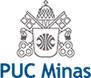  
## Pontifícia Universidade Católica de Minas Gerais

### Pós-Graduação em Ciência de Dados e Big Data

### Ciência de Dados aplicada ao Mercado (Financeiro)

### Gustavo Cariello Ynoue

* Instalação e importação de bibliotecas

In [ ]:
!pip install prophet

In [ ]:
! pip install yfinance --upgrade --no-cache-dir

In [ ]:
! pip install git+https://github.com/quantopian/pyfolio

In [84]:
!pip uninstall scikit-learn -y



In [ ]:
!pip install -U scikit-learn

In [4]:

import numpy as np
import seaborn as sns
import pandas as pd
from pandas import DataFrame
from pandas.testing import assert_frame_equal
import pandas_datareader.data as pdr
import yfinance as yf
yf.pdr_override()
import matplotlib.pyplot as plt
import pyfolio as pf

# bibliotecas para trabalhar offline com a biblioteca
import plotly
import plotly.offline as py
import plotly.graph_objs as go # criará de fato os gráficos
from plotly.offline import plot, iplot
import cufflinks as cf # para conectar o plotly ao pandas
cf.go_offline()
plotly.offline.init_notebook_mode(connected = True)
import plotly.io as pio
pio.renderers
pio.renderers.default = 'colab'

import datetime
import math

%matplotlib inline
sns.set()


from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric


# bibliotecas para deep learning do Keras

import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.layers import LSTM, Dense, Dropout


# bibliotecas para metricas do sklearn

import sklearn.metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# pré processamento

from sklearn.preprocessing import MinMaxScaler

# bibliotecas stasmodels

import statsmodels.api as sm
from scipy import stats

# outras bibliotecas

from IPython.display import Image
import pprint
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



* Carregamento dos dados através da API do Yahoo (IBOV e carteira simulada de ações) e da API do Banco Central do Brasil (Dólar)

Os dados do índice Bovespa (IBOV) e das ações possuem as seguintes colunas:
  - Date: data dos dados
  - Open: preço de abertura
  - High: preço máximo atingido
  - Low: preço mínimo atingido
  - Close: preço de fechamento
  - Adj Close: preço de fechamento após os ajustes para todos os desdobramentos e dividendos apropriados, aderindo aos *Centro de pesquisa de preços de títulos* padrões.
  - Volume: número de ações negociadas no dia

Em alguns casos iremos utilizar as colunas Adj Close ou Close.

A cotação do dólar é obtida através das séries temporais do Banco Central do Brasil, é a taxa de câmbio livre diária em reais com apenas duas colunas:
  - data: data do dado
  - valor: cotação do dólar em real


In [5]:
# Definindo o período de tempo que usaremos para análises dos dados
start_date = '2015-01-01'
end_date = '2020-12-31'

ibov = pdr.get_data_yahoo('^BVSP', start_date, end_date)  # ticker para o IBOV no Yahoo finance

# tickers das 10 ações da carteira simulada
tickers = ['VALE3.SA', 'ITUB4.SA', 'WEGE3.SA', 'CSAN3.SA', 'BPAN4.SA', 'ENEV3.SA', 'GOAU4.SA', 'PETR4.SA', 'OIBR3.SA', 'DIRR3.SA']
carteira = pdr.get_data_yahoo(tickers, start_date, end_date)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  10 of 10 completed


In [6]:
# função para obter dados do Banco Central 
# código 1 = dólar

def dados_bc(codigo):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

dolar = dados_bc(1)

In [12]:
ibov.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1480 entries, 2015-01-02 to 2020-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1480 non-null   float64
 1   High       1480 non-null   float64
 2   Low        1480 non-null   float64
 3   Close      1480 non-null   float64
 4   Adj Close  1480 non-null   float64
 5   Volume     1480 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 80.9 KB


In [13]:
# aqui já vamos definir que iremos trabalhar com preços de fechamento ajustados, ou seja, preços de fechamento já descontados
# os splits, dividendos, etc.

carteira = carteira['Adj Close']
carteira

,BPAN4.SA,CSAN3.SA,DIRR3.SA,ENEV3.SA,GOAU4.SA,ITUB4.SA,OIBR3.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Date,,,,,,,,,,
2015-01-02,2.107640,5.646654,5.300604,5.989072,9.374018,13.777905,6.753943,7.928353,14.682980,5.257324
2015-01-05,1.979349,5.311511,5.045074,5.561281,8.932176,13.847136,6.268853,7.250719,14.462182,5.293169
2015-01-06,1.970186,5.102301,4.900929,5.703878,9.807199,14.071138,5.373302,7.013545,15.041773,5.214652
2015-01-07,1.961022,5.177454,4.992657,5.846475,10.526278,14.580216,5.283747,7.343894,15.593765,5.154906
2015-01-08,2.016004,5.240420,5.084387,5.989072,10.171068,14.808288,5.335988,7.818238,15.759362,5.241961
...,...,...,...,...,...,...,...,...,...,...
2020-12-22,9.801873,18.560478,11.875705,13.972500,10.298053,30.600351,2.110000,24.908234,73.904175,36.029572
2020-12-23,9.956059,18.313368,11.685390,14.555000,10.458665,31.276005,2.160000,25.519983,74.261200,35.930618
2020-12-28,10.096003,18.918787,11.780548,14.687500,10.477560,31.501221,2.220000,25.729984,74.218697,37.355576


In [14]:
dolar = dolar[(dolar.index >= start_date) & (dolar.index <= end_date)]
dolar

,valor
data,
2015-01-02,2.6929
2015-01-05,2.7107
2015-01-06,2.7023
2015-01-07,2.6807
2015-01-08,2.6919
...,...
2020-12-24,5.1800
2020-12-28,5.2390
2020-12-29,5.1942


In [15]:
dolar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1504 entries, 2015-01-02 to 2020-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   valor   1504 non-null   float64
dtypes: float64(1)
memory usage: 23.5 KB


## PARTE 1 

* Pré-processamento e Exploração dos Dados

vamos realizar:
  - verificação e remoção de dados nulos
  - análise estatística
  - plotar gráficos ao longo do tempo
  - analisar correlação entre IBOV e Dólar
  - criar uma carteira de ativos (ações) simulando investimento de 1000 reais por ação
  - normalizar dados
  - avaliar a carteira de investimentos simulada contra o IBOV

In [16]:
ibov.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [17]:
carteira.isnull().sum()

BPAN4.SA    3
CSAN3.SA    1
DIRR3.SA    1
ENEV3.SA    1
GOAU4.SA    1
ITUB4.SA    1
OIBR3.SA    2
PETR4.SA    1
VALE3.SA    1
WEGE3.SA    1
dtype: int64

In [18]:
# vamos remover os dados nulos

carteira = carteira.dropna()
carteira.isnull().sum()

BPAN4.SA    0
CSAN3.SA    0
DIRR3.SA    0
ENEV3.SA    0
GOAU4.SA    0
ITUB4.SA    0
OIBR3.SA    0
PETR4.SA    0
VALE3.SA    0
WEGE3.SA    0
dtype: int64

In [19]:
dolar.isnull().sum()

valor    0
dtype: int64

análise dos dados

In [20]:
ibov['Adj Close'].describe()

count      1480.000000
mean      75318.614189
std       21430.493588
min       37497.000000
25%       56336.250000
50%       74529.000000
75%       95366.000000
max      119528.000000
Name: Adj Close, dtype: float64

In [21]:
ibov['Adj Close'].iplot(title='IBOV')


In [22]:
# podemos utilizar o estilo de gráfico utilizado por traders (candlestick)

ibov.iplot(kind='candle', title='Candles IBOV')

In [23]:
carteira.iplot(title='Carteira')


In [24]:
# como as ações tem escalas diferentes, podemos normalizar para plotar

carteira.normalize().iplot(title='Carteira normalizada')

In [25]:
dolar.describe()

,valor
count,1504.000000
mean,3.797106
std,0.726547
min,2.575400
25%,3.235875
50%,3.713050
75%,4.036975
max,5.937200


In [26]:
dolar.iplot(title='Dólar')


Analisando os dados do IBOV e dólar, vamos plotar os gráficos dos dois índices e verificar a correlação entre eles.

Uma observação interessante em momentos de crise, como o da pandemia em março/2020, pode sugerir a utilização de ativos como o dólar ou ouro, como possível proteção (hedge), com objetivo de minimizar as perdas ou até "empatar", ou mesmo ultrapassá-las, como em eventos únicos chamados de "Cisnes Negros" pelo Nassim Taleb.

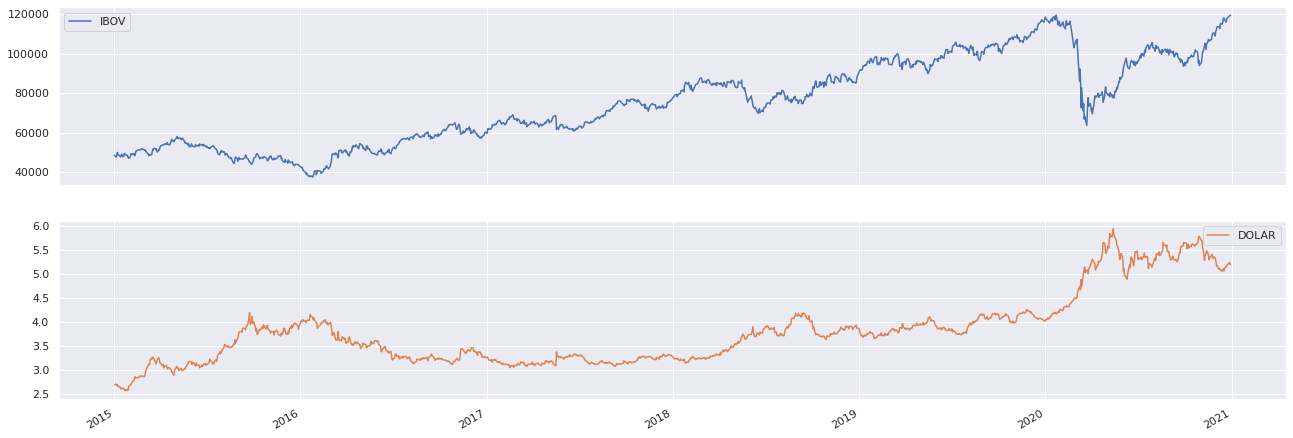

In [27]:
# Plotando os dois gráfios para análise da correlação negativa, no início da pandemia da COVID-19

indices = [ibov['Adj Close'], dolar]
resultado = pd.concat(indices, axis=1, join='inner')
resultado.columns = ['IBOV', 'DOLAR']
resultado.plot(subplots=True, figsize=(22,8))
plt.show()

In [28]:
# correlação entre o IBOV e DOLAR
resultado.corr()

,IBOV,DOLAR
IBOV,1.000000,0.554354
DOLAR,0.554354,1.000000


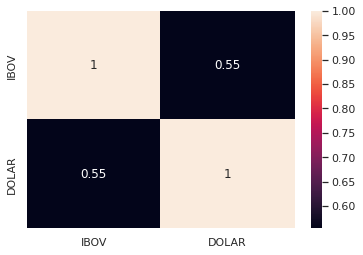

In [29]:
# vamos utilizar o mapa de calor do seaborn

sns.heatmap(resultado.corr(), annot=True)
plt.show()

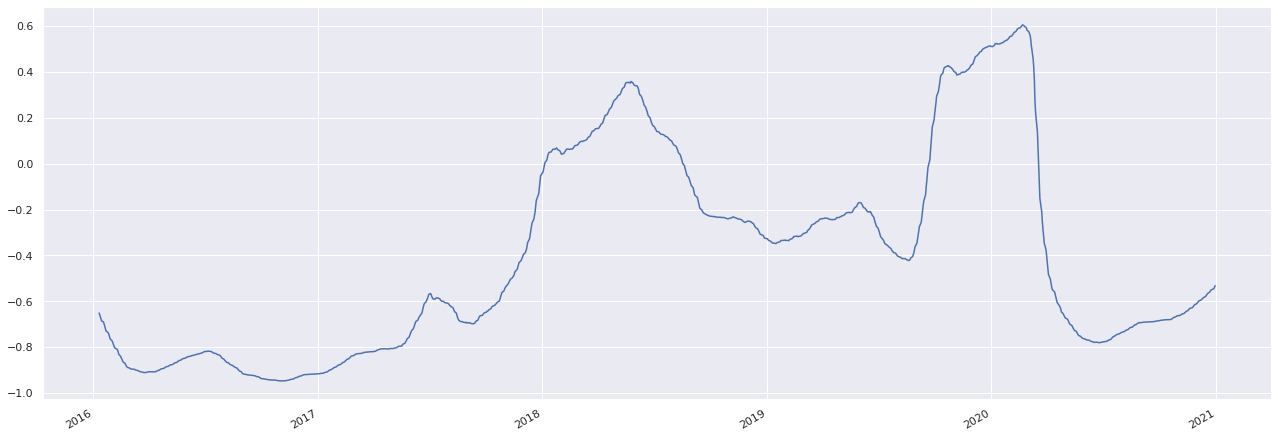

In [30]:
# Uma outra forma de observar essa variação da correlação ao longo do tempo é criando janelas de observação
# usando o rolling em 252 dias úteis, como uma janela de tempo, por exemplo

resultado['DOLAR'].rolling(252).corr(resultado['IBOV']).plot(figsize=(22,8))
plt.show()

Uma outra análise interessante, com a carteira sugerida, é normalizar a mesma e simular um investimento de R$1.000,00 por cada ação da carteira e depois analisar a evolução da mesma ao longo do tempo e "testá-la" contra o IBOV

In [31]:
# normalizando a carteira de investimentos


carteira_normalizada = (carteira / carteira.iloc[0])* 1000
carteira_normalizada

,BPAN4.SA,CSAN3.SA,DIRR3.SA,ENEV3.SA,GOAU4.SA,ITUB4.SA,OIBR3.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Date,,,,,,,,,,
2015-01-02,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
2015-01-05,939.130323,940.647571,951.792312,928.571463,952.865240,1005.024856,928.176803,914.530207,984.962348,1006.817979
2015-01-06,934.782739,903.597322,924.598241,952.380949,1046.210795,1021.282908,795.580006,884.615602,1024.435998,991.883203
2015-01-07,930.434816,916.906599,941.903387,976.190514,1122.920594,1058.231779,782.320375,926.282324,1062.030031,980.518998
2015-01-08,956.521788,928.057605,959.208983,1000.000000,1085.027626,1074.785183,790.055242,986.111173,1073.308189,997.077750
...,...,...,...,...,...,...,...,...,...,...
2020-12-22,4650.639140,3286.987188,2240.443541,2332.999204,1098.574069,2220.972813,312.410085,3141.665447,5033.322725,6853.214684
2020-12-23,4723.794562,3243.224921,2204.539098,2430.259760,1115.707823,2270.011725,319.813196,3218.825183,5057.638303,6834.392705
2020-12-28,4790.193033,3350.442256,2222.491500,2452.383337,1117.723516,2286.357891,328.696887,3245.312523,5054.743567,7105.435010


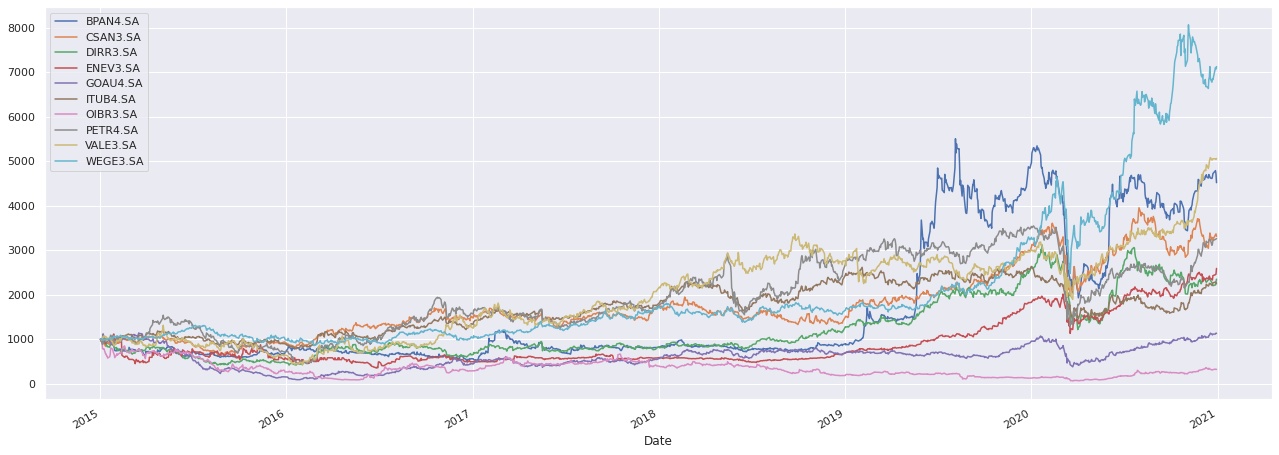

In [32]:
# vamos olhar a evolução no gráfico, todos os ativos saem com valor inicial de 1000 reais

carteira_normalizada.plot(figsize=(22,8))
plt.show()

In [33]:
# para facilitar a interpretação da carteira, vamos criar uma coluna saldo_investido com o somatório da carteira,
# ou seja, investimos inicialmente 1000 reais em cada ação, num total inicial de 10.000 reais,
# dessa forma poderemos avaliar em termos monetários, a evolução da mesma.

carteira_normalizada['saldo_investido'] = carteira_normalizada.sum(axis=1)  # axis=1 para somar as linhas
carteira_normalizada

,BPAN4.SA,CSAN3.SA,DIRR3.SA,ENEV3.SA,GOAU4.SA,ITUB4.SA,OIBR3.SA,PETR4.SA,VALE3.SA,WEGE3.SA,saldo_investido
Date,,,,,,,,,,,
2015-01-02,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,10000.000000
2015-01-05,939.130323,940.647571,951.792312,928.571463,952.865240,1005.024856,928.176803,914.530207,984.962348,1006.817979,9552.519100
2015-01-06,934.782739,903.597322,924.598241,952.380949,1046.210795,1021.282908,795.580006,884.615602,1024.435998,991.883203,9479.367762
2015-01-07,930.434816,916.906599,941.903387,976.190514,1122.920594,1058.231779,782.320375,926.282324,1062.030031,980.518998,9697.739417
2015-01-08,956.521788,928.057605,959.208983,1000.000000,1085.027626,1074.785183,790.055242,986.111173,1073.308189,997.077750,9850.153539
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,4650.639140,3286.987188,2240.443541,2332.999204,1098.574069,2220.972813,312.410085,3141.665447,5033.322725,6853.214684,31171.228895
2020-12-23,4723.794562,3243.224921,2204.539098,2430.259760,1115.707823,2270.011725,319.813196,3218.825183,5057.638303,6834.392705,31418.207275
2020-12-28,4790.193033,3350.442256,2222.491500,2452.383337,1117.723516,2286.357891,328.696887,3245.312523,5054.743567,7105.435010,31953.779521


In [34]:
# vamos normalizar também o IBOV  para podermos comparar com a carteira sugerida

ibov_normalizado = (ibov['Adj Close'] / ibov['Adj Close'].iloc[0]) * 10000
ibov_normalizado

Date
2015-01-02    10000.000000
2015-01-05     9794.896108
2015-01-06     9894.665237
2015-01-07    10196.033971
2015-01-08    10294.978562
                  ...     
2020-12-22    23983.344327
2020-12-23    24294.401385
2020-12-28    24540.526055
2020-12-29    24627.927111
2020-12-30    24593.090369
Name: Adj Close, Length: 1480, dtype: float64

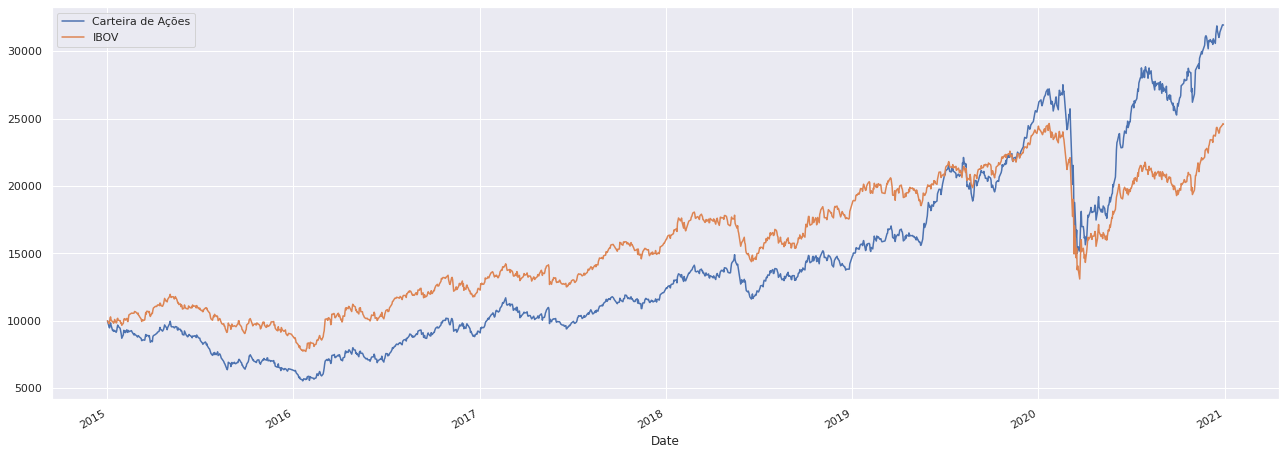

In [35]:
# plotando o IBOV e a carteira normalizados e comparando a evolução ao longo do tempo
# podemos avaliar que após o início da pandemia, a carteira vem se recuperando, acima do IBOV

carteira_normalizada['saldo_investido'].plot(figsize=(22,8), label='Carteira de Ações')
ibov_normalizado.plot(label='IBOV')
plt.legend()
plt.show()

In [36]:
ibov = ibov['Adj Close']
ibov

Date
2015-01-02     48512.0
2015-01-05     47517.0
2015-01-06     48001.0
2015-01-07     49463.0
2015-01-08     49943.0
                ...   
2020-12-22    116348.0
2020-12-23    117857.0
2020-12-28    119051.0
2020-12-29    119475.0
2020-12-30    119306.0
Name: Adj Close, Length: 1480, dtype: float64

In [37]:
# carteira e IBOV

ativos_indice = [carteira, ibov]
carteira_ibov = pd.concat(ativos_indice, axis=1)  # concatenando num unico dataframe
carteira_ibov = carteira_ibov.rename(columns={'Adj Close': 'IBOV'})  # renomeando o nome da coluna
carteira_ibov


,BPAN4.SA,CSAN3.SA,DIRR3.SA,ENEV3.SA,GOAU4.SA,ITUB4.SA,OIBR3.SA,PETR4.SA,VALE3.SA,WEGE3.SA,IBOV
Date,,,,,,,,,,,
2015-01-02,2.107640,5.646654,5.300604,5.989072,9.374018,13.777905,6.753943,7.928353,14.682980,5.257324,48512.0
2015-01-05,1.979349,5.311511,5.045074,5.561281,8.932176,13.847136,6.268853,7.250719,14.462182,5.293169,47517.0
2015-01-06,1.970186,5.102301,4.900929,5.703878,9.807199,14.071138,5.373302,7.013545,15.041773,5.214652,48001.0
2015-01-07,1.961022,5.177454,4.992657,5.846475,10.526278,14.580216,5.283747,7.343894,15.593765,5.154906,49463.0
2015-01-08,2.016004,5.240420,5.084387,5.989072,10.171068,14.808288,5.335988,7.818238,15.759362,5.241961,49943.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,9.801873,18.560478,11.875705,13.972500,10.298053,30.600351,2.110000,24.908234,73.904175,36.029572,116348.0
2020-12-23,9.956059,18.313368,11.685390,14.555000,10.458665,31.276005,2.160000,25.519983,74.261200,35.930618,117857.0
2020-12-28,10.096003,18.918787,11.780548,14.687500,10.477560,31.501221,2.220000,25.729984,74.218697,37.355576,119051.0


In [38]:
# vamos trabalhar com os retornos dos ativos em percentual, preparando para trabalharmos com retornos acumulados

retorno_ativos = carteira_ibov.pct_change()
retorno_ativos

,BPAN4.SA,CSAN3.SA,DIRR3.SA,ENEV3.SA,GOAU4.SA,ITUB4.SA,OIBR3.SA,PETR4.SA,VALE3.SA,WEGE3.SA,IBOV
Date,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.060870,-0.059352,-0.048208,-0.071429,-0.047135,0.005025,-0.071823,-0.085470,-0.015038,0.006818,-0.020510
2015-01-06,-0.004629,-0.039388,-0.028571,0.025641,0.097963,0.016177,-0.142857,-0.032710,0.040076,-0.014834,0.010186
2015-01-07,-0.004651,0.014729,0.018716,0.025000,0.073322,0.036179,-0.016667,0.047102,0.036697,-0.011457,0.030458
2015-01-08,0.028037,0.012162,0.018373,0.024390,-0.033745,0.015643,0.009887,0.064590,0.010619,0.016888,0.009704
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,0.008057,0.017613,-0.014218,-0.006400,-0.014467,0.004823,0.000000,0.009623,0.000921,0.011248,0.002862
2020-12-23,0.015730,-0.013314,-0.016026,0.041689,0.015596,0.022080,0.023697,0.024560,0.004831,-0.002746,0.012970
2020-12-28,0.014056,0.033059,0.008143,0.009103,0.001807,0.007201,0.027778,0.008229,-0.000572,0.039659,0.010131


In [39]:
# agora trabalhamos com retornos acumulados e iniciamos os dados com valor unitário
# dessa forma entendemos melhor a evolução de cada ativo


retorno_ativos_acumulado = (1 + retorno_ativos).cumprod()  # obtemos o produtório
retorno_ativos_acumulado.iloc[0] = 1  # definimos o primeiro valor como 1
retorno_ativos_acumulado

,BPAN4.SA,CSAN3.SA,DIRR3.SA,ENEV3.SA,GOAU4.SA,ITUB4.SA,OIBR3.SA,PETR4.SA,VALE3.SA,WEGE3.SA,IBOV
Date,,,,,,,,,,,
2015-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2015-01-05,0.939130,0.940648,0.951792,0.928571,0.952865,1.005025,0.928177,0.914530,0.984962,1.006818,0.979490
2015-01-06,0.934783,0.903597,0.924598,0.952381,1.046211,1.021283,0.795580,0.884616,1.024436,0.991883,0.989467
2015-01-07,0.930435,0.916907,0.941903,0.976191,1.122921,1.058232,0.782320,0.926282,1.062030,0.980519,1.019603
2015-01-08,0.956522,0.928058,0.959209,1.000000,1.085028,1.074785,0.790055,0.986111,1.073308,0.997078,1.029498
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,4.650639,3.286987,2.240444,2.332999,1.098574,2.220973,0.312410,3.141665,5.033323,6.853215,2.398334
2020-12-23,4.723795,3.243225,2.204539,2.430260,1.115708,2.270012,0.319813,3.218825,5.057638,6.834393,2.429440
2020-12-28,4.790193,3.350442,2.222491,2.452383,1.117724,2.286358,0.328697,3.245313,5.054744,7.105435,2.454053


In [40]:
# agora vamos visualizar os dados de nossa carteira em termos de valores (reais)
# para isso vamos alocar o valor de 1000 reais para cada ação, utilizar somente os dados das ações sem o IBOV
# e criar duas colunas:
# saldo_investido = o total em reais da nossa carteira
# retorno = retorno comparado, para avaliarmos a evolução (percentual)

carteira_avaliacao = 1000 * retorno_ativos_acumulado.iloc[: , :10]

# vamos criar as colunas saldo_investido e retorno (percentual)
carteira_avaliacao['saldo_investido'] = carteira_avaliacao.sum(axis=1)
carteira_avaliacao['retorno'] = carteira_avaliacao['saldo_investido'].pct_change()
carteira_avaliacao

,BPAN4.SA,CSAN3.SA,DIRR3.SA,ENEV3.SA,GOAU4.SA,ITUB4.SA,OIBR3.SA,PETR4.SA,VALE3.SA,WEGE3.SA,saldo_investido,retorno
Date,,,,,,,,,,,,
2015-01-02,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,10000.000000,NaN
2015-01-05,939.130323,940.647571,951.792312,928.571463,952.865240,1005.024856,928.176803,914.530207,984.962348,1006.817979,9552.519100,-0.044748
2015-01-06,934.782739,903.597322,924.598241,952.380949,1046.210795,1021.282908,795.580006,884.615602,1024.435998,991.883203,9479.367762,-0.007658
2015-01-07,930.434816,916.906599,941.903387,976.190514,1122.920594,1058.231779,782.320375,926.282324,1062.030031,980.518998,9697.739417,0.023037
2015-01-08,956.521788,928.057605,959.208983,1000.000000,1085.027626,1074.785183,790.055242,986.111173,1073.308189,997.077750,9850.153539,0.015716
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,4650.639140,3286.987188,2240.443541,2332.999204,1098.574069,2220.972813,312.410085,3141.665447,5033.322725,6853.214684,31171.228895,0.004902
2020-12-23,4723.794562,3243.224921,2204.539098,2430.259760,1115.707823,2270.011725,319.813196,3218.825183,5057.638303,6834.392705,31418.207275,0.007923
2020-12-28,4790.193033,3350.442256,2222.491500,2452.383337,1117.723516,2286.357891,328.696887,3245.312523,5054.743567,7105.435010,31953.779521,0.017047


Start date,2015-01-02
End date,2020-12-30
Total months,70
,Backtest
Annual return,21.766%
Cumulative returns,219.393%
Annual volatility,29.917%
Sharpe ratio,0.81
Calmar ratio,0.48
Stability,0.88
Max drawdown,-45.418%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,45.42,2020-02-19,2020-03-18,2020-07-17,108
1,44.54,2015-01-02,2016-01-20,2016-10-21,471
2,22.06,2018-05-16,2018-06-18,2018-11-05,124
3,19.69,2017-02-21,2017-06-20,2017-09-15,149
4,14.61,2019-08-08,2019-08-26,2019-11-04,63


Stress Events,mean,min,max
Fall2015,-0.26%,-4.14%,5.72%
New Normal,0.10%,-18.99%,16.12%


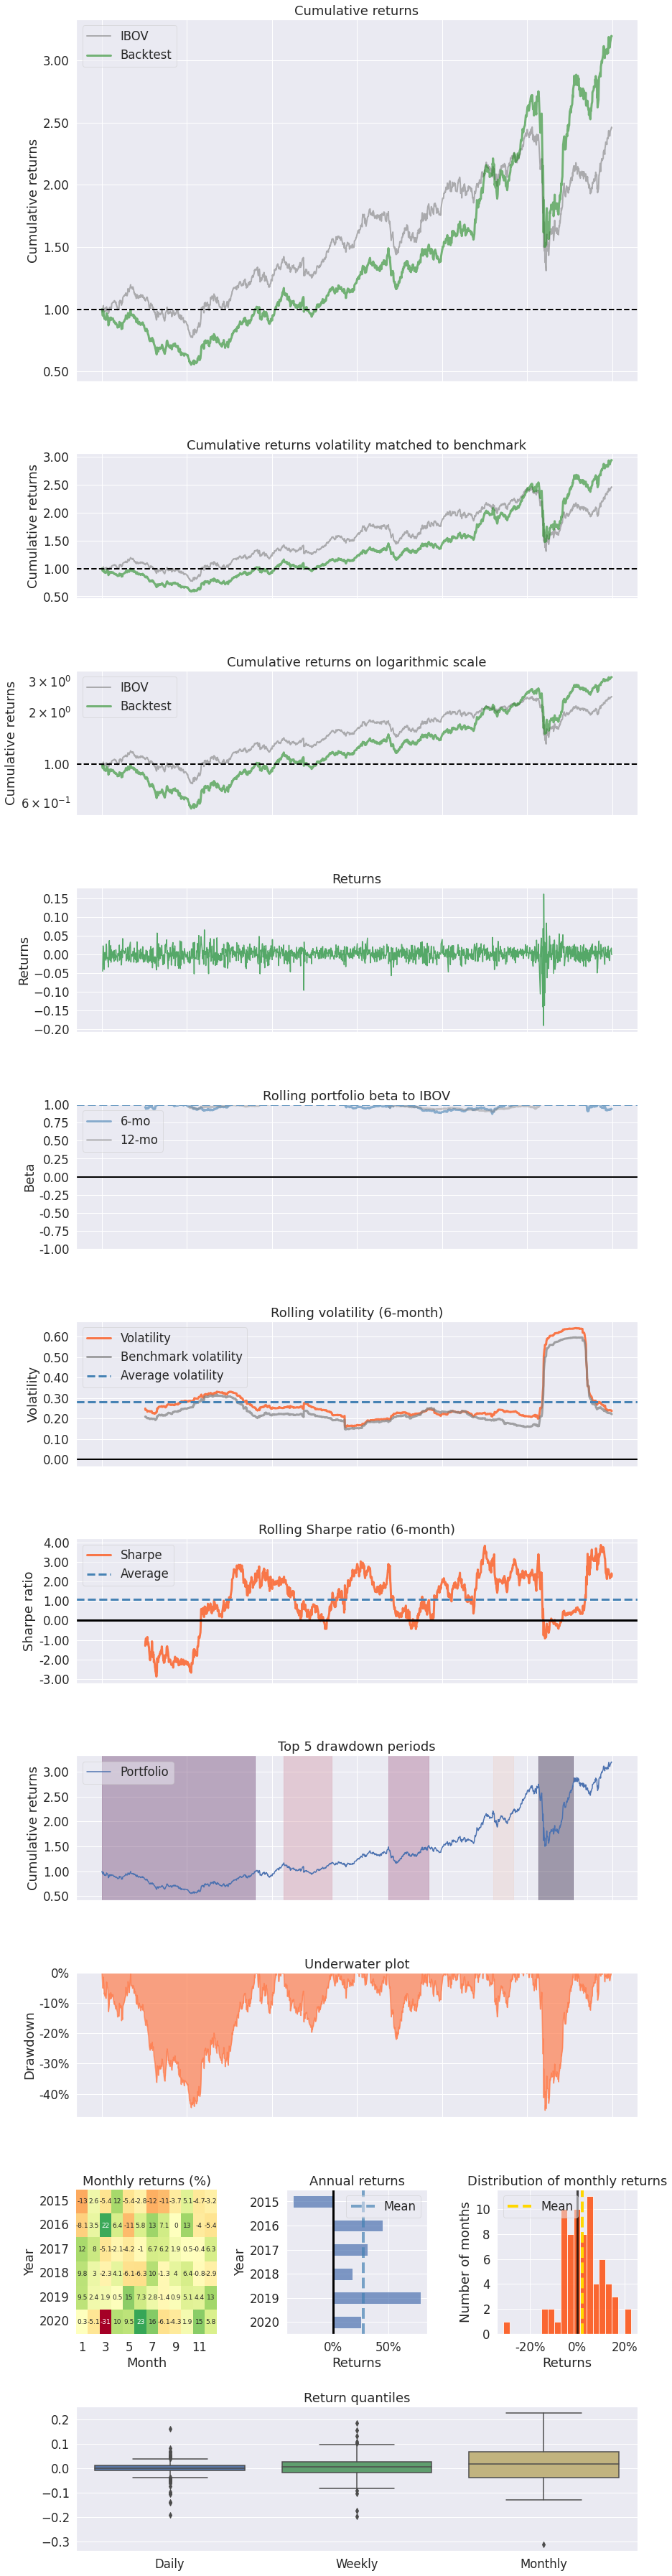

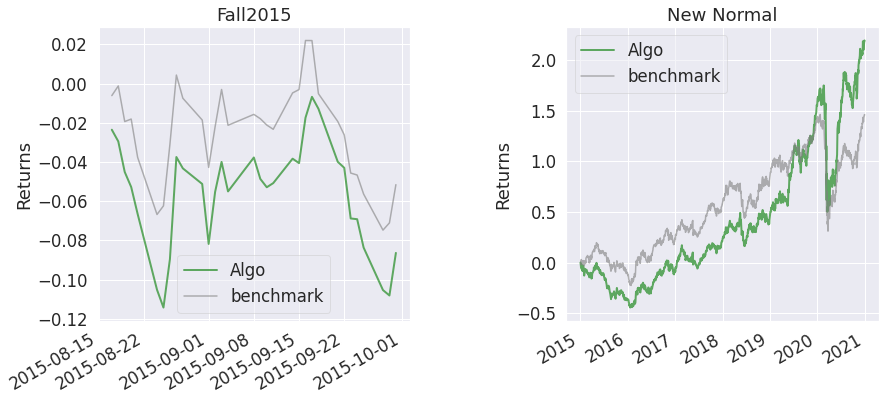

In [41]:
# avaliação do retorno da carteira em relação ao IBOV (back test)

pf.create_full_tear_sheet(carteira_avaliacao['retorno'], benchmark_rets=retorno_ativos['IBOV'])

## PARTE 2 - modelos preditivos

* Aqui iniciamos a demonstração de dois modelos utilizando a ação ITUB4 - Itaú Unibanco.

Dataset de treinamento de 2015 a 2020
Dataset de teste 2021
  - um modelo preditivo para séries temporais utilizando a biblioteca prophet do Facebook
  - um modelo de Redes Neurais Recorrentes (LSTM - Long Short Term Memory), muito utilizado em dados financeiros 

In [42]:
# período de treinamento

train_start_date = start_date
train_end_date = end_date

# período de testes para serem utilizadas nos modelos de predição em testes de algoritmos

test_start_date = '2021-01-01'
test_end_date = '2021-08-31'

In [43]:
# carregamento dos dados de treinamento e teste

train_dataset_itub4 = pdr.get_data_yahoo('ITUB4.SA', train_start_date, train_end_date)
test_dataset_itub4 = pdr.get_data_yahoo('ITUB4.SA', test_start_date, test_end_date)

train_itub4_prophet = train_dataset_itub4
test_itub4_prophet = test_dataset_itub4

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [44]:
# para o treinamento e teste iremos utilizar apenas a coluna Close, removendo as demais

train_itub4_prophet = train_itub4_prophet.drop(columns = ['Open', 'High', 'Low', 'Volume', 'Adj Close'])
test_itub4_prophet = test_itub4_prophet.drop(columns = ['Open', 'High', 'Low', 'Volume', 'Adj Close'])
train_itub4_prophet.head()

,Close
Date,
2015-01-02,18.639118
2015-01-05,18.732782
2015-01-06,19.035812
2015-01-07,19.724518
2015-01-08,20.033056


In [45]:
# renomeia as colunas 'Close' para 'y' e 'Date' para 'ds' do conjunto de treinamento

train_itub4_prophet = pd.DataFrame({'ds': train_itub4_prophet.index, 'y': train_itub4_prophet.Close})
train_itub4_prophet.reset_index(drop = True, inplace=True)
train_itub4_prophet.tail()

,ds,y
1483,2020-12-22,31.250000
1484,2020-12-23,31.940001
1485,2020-12-28,32.169998
1486,2020-12-29,32.099998
1487,2020-12-30,31.629999


In [46]:
# renomeia as colunas 'Close' para 'y_test' e 'Date' para 'ds_test' do conjunto de teste

test_itub4_prophet = pd.DataFrame({'ds_test': test_itub4_prophet.index, 'y_test': test_itub4_prophet.Close})
test_itub4_prophet.reset_index(drop=True, inplace=True)
test_itub4_prophet.head()

,ds_test,y_test
0,2021-01-04,30.900000
1,2021-01-05,30.700001
2,2021-01-06,31.600000
3,2021-01-07,32.830002
4,2021-01-08,32.820000


In [47]:
# realizando a previsão com a biblioteca Prophet

prophet_model = Prophet(changepoint_prior_scale=0.05, interval_width=0.95, daily_seasonality=False)
prophet_model.fit(train_itub4_prophet)

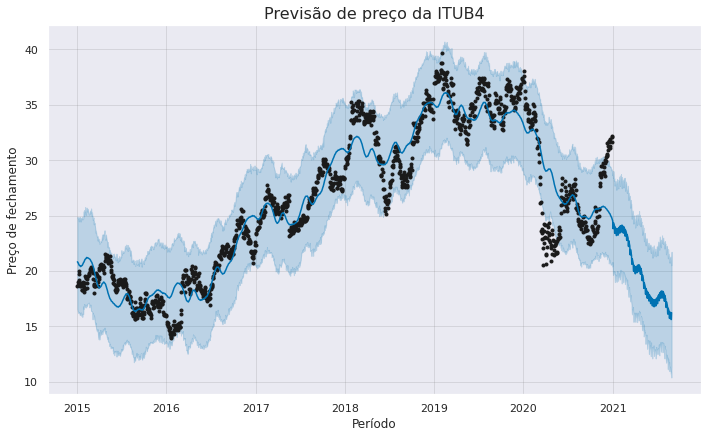

In [48]:
# cria datas futuras e faz a predição

prophet_forecast = prophet_model.make_future_dataframe(periods=243, freq='D')
prophet_forecast = prophet_model.predict(prophet_forecast)

# plotagem do gráfico de predição
# observa uma tendencia de alta da ação

fig = prophet_model.plot(prophet_forecast)
ax1 = fig.gca()
ax1.set_title('Previsão de preço da ITUB4', fontsize=16)
ax1.set_xlabel('Período', fontsize=12)
ax1.set_ylabel('Preço de fechamento', fontsize=12)
plt.show()

In [49]:
# seleciona os dados previstos apenas para o período de teste

prophet_forecast = prophet_forecast[prophet_forecast['ds'] > train_end_date]
prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1489,2021-01-01,23.065047,20.291506,28.654214,23.065047,23.065047,1.450486,1.450486,1.450486,0.157130,0.157130,0.157130,1.293356,1.293356,1.293356,0.0,0.0,0.0,24.515533
1490,2021-01-02,23.041299,19.624082,28.468077,23.041299,23.041299,0.833206,0.833206,0.833206,-0.418520,-0.418520,-0.418520,1.251725,1.251725,1.251725,0.0,0.0,0.0,23.874505
1491,2021-01-03,23.017551,19.703157,28.401357,23.017387,23.018242,0.791320,0.791320,0.791320,-0.418520,-0.418520,-0.418520,1.209840,1.209840,1.209840,0.0,0.0,0.0,23.808871
1492,2021-01-04,22.993802,19.984395,29.004937,22.990615,22.997947,1.363538,1.363538,1.363538,0.195252,0.195252,0.195252,1.168286,1.168286,1.168286,0.0,0.0,0.0,24.357340
1493,2021-01-05,22.970054,19.696379,28.587566,22.965393,22.975626,1.309984,1.309984,1.309984,0.182299,0.182299,0.182299,1.127685,1.127685,1.127685,0.0,0.0,0.0,24.280038


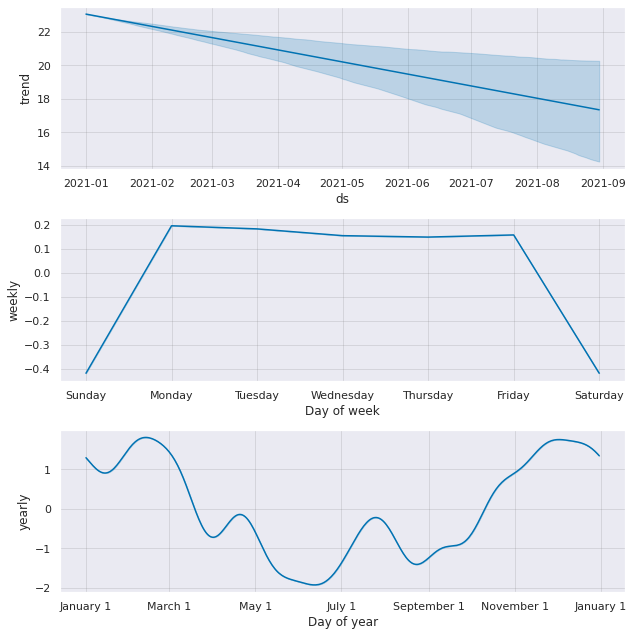

In [50]:
# plotagem dos componentes da previsão de forma separada

fig = prophet_model.plot_components(prophet_forecast)

In [51]:
# exclusão dos fins de semana nos dados previstos

prophet_forecast = prophet_forecast[prophet_forecast['ds'].dt.dayofweek < 5]

# exclusão dos feriados nos dados previstos (2021)

holidays = pd.DataFrame({
    'holida': 'holiday',
    'ds': pd.to_datetime(['2021-01-01', '2021-01-25', '2021-02-15', '2021-02-16', '2021-04-02', '2021-04-21', '2021-06-03', '2021-07-09'])
})

prophet_forecast = prophet_forecast[~prophet_forecast['ds'].isin(holidays['ds'])]
prophet_forecast = prophet_forecast.dropna()

In [52]:
# escolhe as datas (ds e ds_test) como índices

prophet_forecast.set_index(prophet_forecast['ds'], inplace=True)
test_itub4_prophet.set_index(test_itub4_prophet['ds_test'], inplace=True)
train_itub4_prophet.set_index(train_itub4_prophet['ds'], inplace=True)

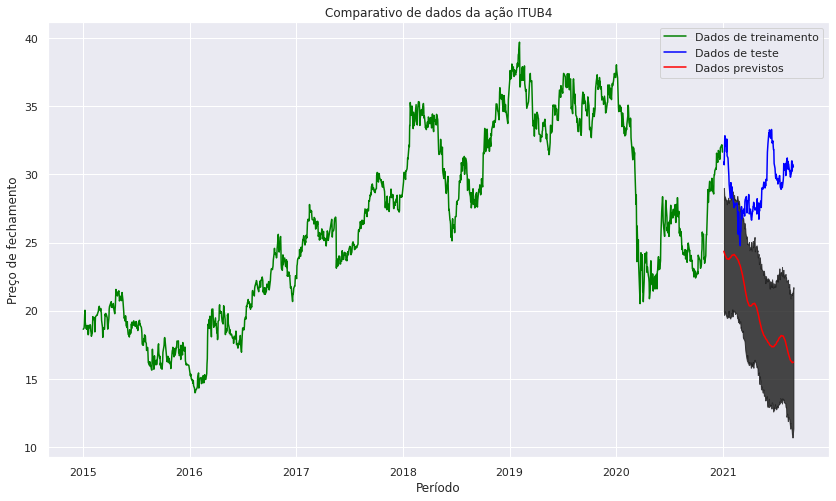

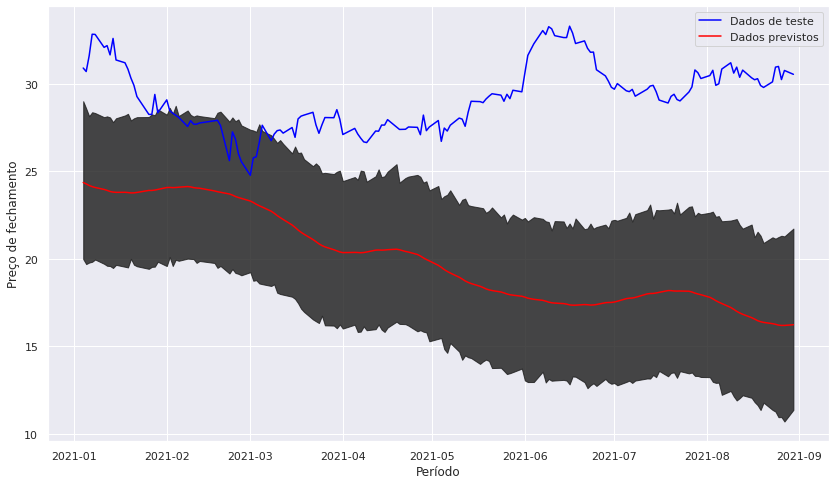

In [54]:
# plotagem do comparativo entre o preço previsto e o dataset

n = train_itub4_prophet.shape[0]
plt.figure(figsize=(14,8))
plt.title('Comparativo de dados da ação ITUB4')
plt.plot(train_itub4_prophet['y'], color='green', label='Dados de treinamento')
plt.plot(test_itub4_prophet['y_test'], color='blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'][-n:], color='red', label='Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=0.8)
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)

# plotagem do comparativo entre o preço previsto e o preço de validação

plt.figure(figsize=(14,8))
plt.plot(test_itub4_prophet['y_test'], color='blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'], color='red', label='Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=0.8)
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
plt.show()

Modelo preditivo com RNN com arquitetura LSTM (long short term memory)

In [55]:
# carregamento dos dados

train_itub4_lstm = train_dataset_itub4
df_train = train_itub4_lstm.drop(['Adj Close', 'Open', 'Low', 'High', 'Volume'], axis=1)
test_itub4_lstm = test_dataset_itub4
df_test = test_itub4_lstm.drop(['Adj Close', 'Open', 'Low', 'High', 'Volume'], axis=1)

df_train.columns = ['Preco']
df_test.columns = ['Preco']

In [56]:
df_train.head()

,Preco
Date,
2015-01-02,18.639118
2015-01-05,18.732782
2015-01-06,19.035812
2015-01-07,19.724518
2015-01-08,20.033056


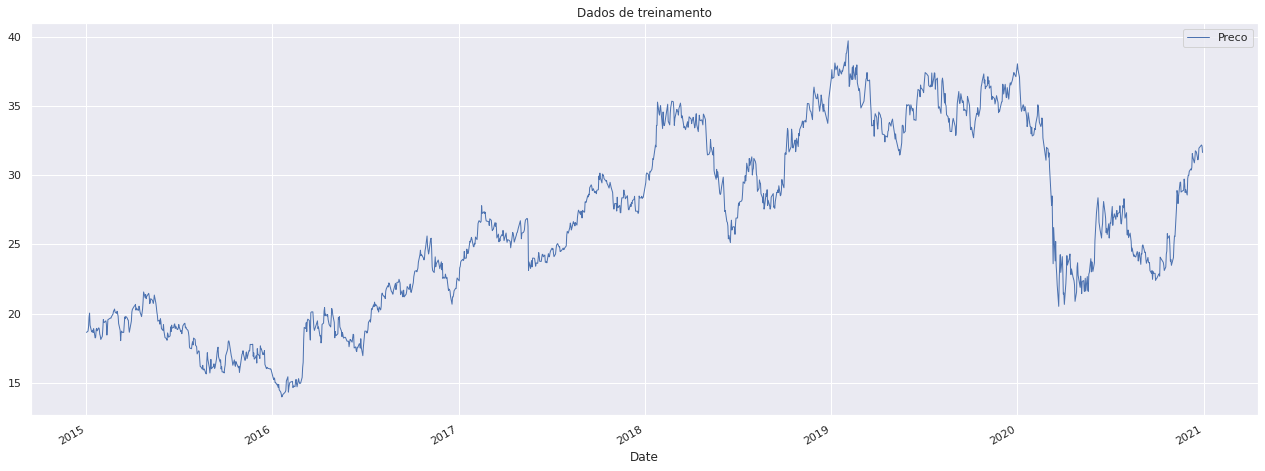

In [57]:
df_train.plot(figsize=(22,8), title='Dados de treinamento', linewidth=1)
plt.show()

In [58]:
df_test.head()

,Preco
Date,
2021-01-04,30.900000
2021-01-05,30.700001
2021-01-06,31.600000
2021-01-07,32.830002
2021-01-08,32.820000


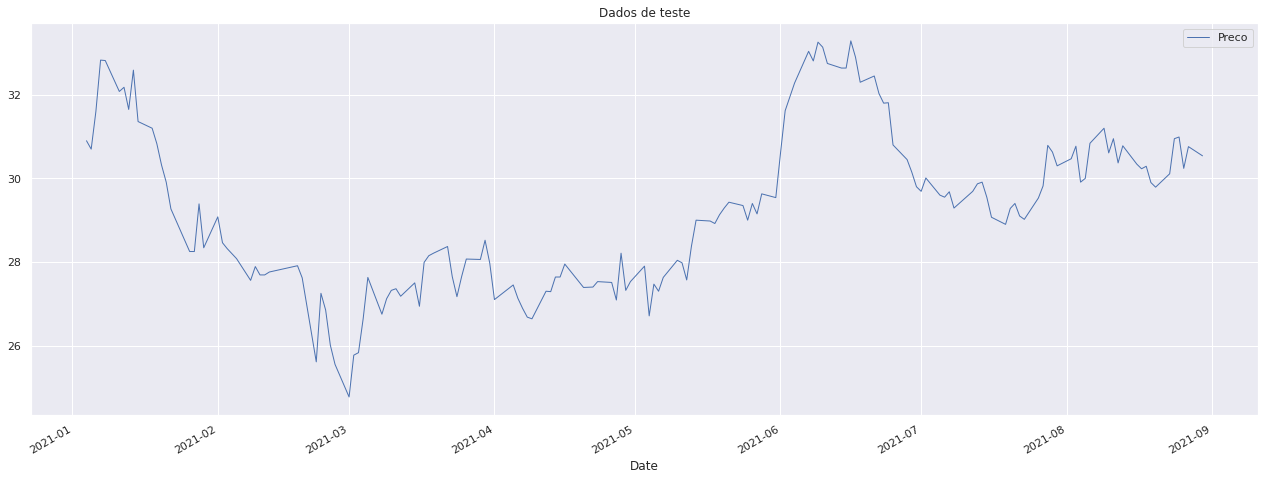

In [59]:
df_test.plot(figsize=(22,8), title='Dados de teste', linewidth=1)
plt.show()

In [60]:
# Resultados do modelo

dict_resultados = {}

def mostra_resultado_modelo(df_train, df_test, y_previsao, nome_modelo):
  previsao_futura = pd.DataFrame(y_previsao,
                                 index=df_test.index,
                                 columns=['previsao'])
  
  mape = mean_absolute_percentage_error(df_test, y_previsao) * 100

  mse = mean_squared_error(df_test, y_previsao, squared=True)
  dict_resultados[nome_modelo] = [mape, mse]

  pd.concat([df_test, previsao_futura], axis=1).plot()
  plt.title(f'MAPE = {mape:.2f} % | MSE = {mse:.2f}', fontsize=25)
  plt.xlabel('Tempo (dias)', fontsize=20)
  plt.ylabel('Preço (R$)', fontsize=20)
  plt.legend()
  plt.show()


In [61]:
# vamos normalizar os dados

train_max = df_train.max()
train_min = df_train.min()

train = (df_train - train_min) / (train_max - train_min)
test = (df_test - train_min) / (train_max - train_min)

In [62]:
# função para criar dataset

def cria_dataset(X, y, time_steps=1):
  Xs, ys = [], []

  for i in range(len(X) - time_steps):
    v = X.iloc[i:(i + time_steps)].values
    Xs.append(v)
    ys.append(y.iloc[i + time_steps])

  return np.array(Xs).astype('float32'), np.array(ys).astype('float32')

In [63]:
time_steps = 1

X_train, y_train = cria_dataset(train, train['Preco'], time_steps)
X_test, y_test = cria_dataset(test, test['Preco'], time_steps)

Modelo Sequential

In [64]:
# Modelo Sequential

model_lstm = Sequential(name='lstm_itub4')
model_lstm

Input Layer - 01 camada

In [65]:
# Primeira camada (Input Layer) LSTM e regularização de dropout

model_lstm.add(LSTM(units=len(df_train.columns),
                    return_sequences=True,
                    input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))

Hidden Layers - 03 camadas

In [66]:
# Segunda camada (Hidden Layer) LSTM e regularização de dropout

model_lstm.add(LSTM(units=10, return_sequences=True))
model_lstm.add(Dropout(0.2))

# Terceira camada (Hidden Layer) LSTM e regularização de dropout

model_lstm.add(LSTM(units=10, return_sequences=True))
model_lstm.add(Dropout(0.2))

# Quarta camada (Hidden Layer) LSTM e dropout

model_lstm.add(LSTM(units=10))
model_lstm.add(Dropout(0.2))

Outupu Layer - 01 camada

In [68]:
# Camada de saída usando o Dense

model_lstm.add(Dense(units=1))

Compilação da RNA

In [69]:
# RNA

model_lstm.compile(loss='mean_squared_error',
                   optimizer='adam',
                   metrics=['mse', 'mape'])

Resumo da RNA

In [70]:
# Summary

model_lstm.summary()

Model: "lstm_itub4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 1)              12        
_________________________________________________________________
dropout (Dropout)            (None, 1, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 10)             480       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 10)             840       
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                8

Treinamento

In [71]:
# vamos criar lote de treinamento de 30 em 30 dias

%%time

history = model_lstm.fit(X_train,
                          y_train,
                          epochs=1000,
                          batch_size=30,
                          shuffle=False,
                          validation_split=0.30,
                          verbose=0)
history

CPU times: user 5min 23s, sys: 12.9 s, total: 5min 36s
Wall time: 4min 28s


In [72]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'mape', 'val_loss', 'val_mse', 'val_mape'])


In [73]:
best_epochs = history.history['loss'].index(min(history.history['loss']))
best_epochs

582

In [74]:
min(history.history['loss'])

0.012980309315025806

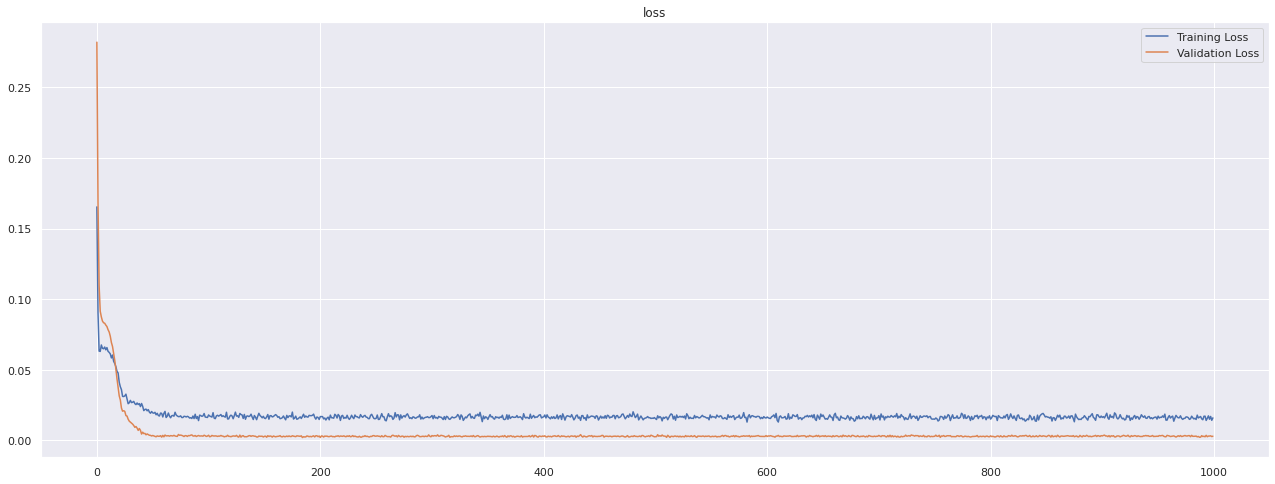

In [75]:
# plotar loss

plt.rc('figure', figsize=(22,8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('loss')
plt.legend()
plt.show()

Previsão

In [76]:
y_pred = model_lstm.predict(X_test)

In [77]:
# redimensionar os dados ao tamanho original

y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]
y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]
y_train = y_train*(train_max[0] - train_min[0]) + train_min[0]

In [78]:
y_test[:10]

array([30.7     , 31.599998, 32.83    , 32.82    , 32.08    , 32.18    ,
       31.649998, 32.59    , 31.36    , 31.2     ], dtype=float32)

In [79]:
len(y_test)

162

In [80]:
y_train[:10]

array([18.732782, 19.035812, 19.724518, 20.033056, 19.157024, 18.694214,
       18.672176, 18.798899, 18.633608, 18.92011 ], dtype=float32)

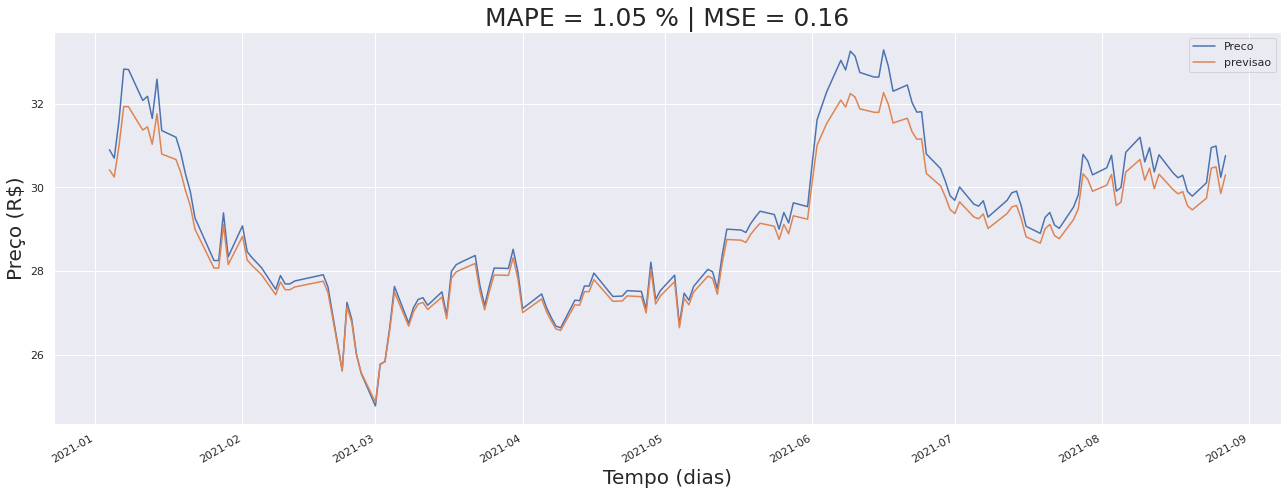

In [81]:
mostra_resultado_modelo(df_train=df_test['Preco'][:162],
                        df_test=df_test['Preco'][:162],
                        y_previsao=y_pred[:162],
                        nome_modelo='model_lstm')

Resultados

In [82]:
dict_resultados

{'model_lstm': [1.046831026234093, 0.1590756281063848]}